## Data literacy exercise 04

Machine Learning in Science, University of Tübingen, Winter Semester 2022



## Theoretical Part

### 1. EXAMple Question — iPhone sales

(a) Observing a single serial number $x_i$ from a set of possible observations $X = \{x_1, ..., x_N\}$ where $N$ is the only parameter of our model, reaffirms our belief about said parameter $N$.

Given a model $\theta$ with parameter $N$, a single sample can only either support the model fully (in case $x_i \leq N$), or disprove the model (in case $x_i \geq N$). In the latter case, the drawn $x_i$ becomes our new estimate for the model.

The probability for observing $x_i$ with fixed $N$ is $P(x_i | \theta = N) = \frac{1}{N}$. For i.i.d data, the maximum likelihood estimate for $N$ is given by 
$$\theta_{MLE} = \text{argmax}_{\theta} \left( \sum_{i}^D log(x_i | \theta)\right)$$

Since we model a uniform distribution, the theta which maximizes the likelihoods for the individual observations is equal to the maximum observation.

An alternative to the simple MLE is given briefly. We want to express our belief about the model $\theta$ given a series of data. Intuitively, we would never expect to draw the maximum $x_i = N$ for a low sample size, although we would think that our maximum observed $x_i$ comes closer to the true $N$ as we increase sample size.

This is captured in the estimator $\hat{N} = \frac{(M-1)(S+1)}{S}$ presented in $\texttt{https://www.theguardian.com/technology/blog/2008/oct/08/iphone.apple}$, where $M$ is the maximum observation and $S$ is the sample size.



(b) From (a), we can directly see that $ \theta_{MLE} = \text{max}_i \{x_i \in D\} = 3872915$.

(c) The sample size $S = 5$ is very small, increasing the uncertainty about the estimated parameter $\hat{N}$. The problem lies with the dependence on the occurence of a sample close to the true $N$. Assume that we would not have observed $x_4 = 3872915$. This would have a dramatic impact on the estimated parameter.

### 2. Theory Question — Exam room booking


(a) The probability for a single observation $k$ given the binomial model $\theta$ is given by 
$$P(k | \theta) = \binom{n}{k}p^{k}(1-p)^{n-k}$$

The joint likelihood of the N i.i.d. samples is given by 
$$\prod_{i}^{N}P(x_i | \theta)$$

(b) 

$
\begin{align*}
\theta_{MLE} &= \text{argmax}_{\theta} \left(\prod_{i}^{N}P(x_i | \theta)\right)\\
&= \text{argmax}_{\theta} \left(\sum_{i}^N log(\binom{n}{k}\theta^{k}(1-\theta)^{n-k})\right)\\
&= \text{argmax}_{\theta} \left(\sum_{i}^N k\cdot log(\theta) + (n-k)\cdot log(1-\theta)\right)\\
&= \text{argmin}_{\theta} \left(\sum_{i}^N -k\cdot log(\theta) - (n-k)\cdot log(1-\theta)\right)
\end{align*}$

$\Rightarrow \text{find minimum for }\theta$

$\begin{align*}
\nabla_{\theta}L &= \sum_{i}^N \left( -\frac{k}{\theta} - \frac{k-n}{1 - \theta}\right)\\
&= \sum_{i}^N \left( -\frac{k(1 - \theta) + \theta (k- n)}{\theta (1 -  \theta)}\right)\\
&= \sum_{i}^N \left( \frac{\theta n - k}{\theta (1 -  \theta)}\right) \overset{!}{=} 0\\
&\Rightarrow N\cdot n \cdot \theta - k_1 - k_2 - ... - k_N\overset{!}{=} 0\\
&\Rightarrow \theta = \frac{\sum_{i}^N k_i}{N\cdot n}
\end{align*}$

$\theta_{MLE} = \frac{883}{13 \cdot 100} \approx 0.679$

(c) The probability of accomodating all students is the probability for observing 0 to 75 students to come to the exam. Thus, we sum over all proabbilities ($P(k = 0|\theta) + P(k = 1|\theta) + ... + P(k = 75|\theta)$) given $\theta = 0.679$.

In [1]:
from math import comb
N = 100
res = sum([comb(N,k) * 0.679**k * (1-0.679)**(N-k) for k in range(1, 76)])
res

0.9508533262379899

Thus, we can see, that there is a 95% chance of getting everybody a seat, if booking a room with size 75.

### Introduction

In this notebook, you will calculate the mean age of the Titanic passengers and use bootstrapping to compute the respective confidence intervals. You will use the well-known [titanic dataset](https://www.kaggle.com/competitions/titanic/data?select=train.csv).

Consider a dataset $D = \{x_1,\dots,x_N \}$ assumed to be drawn i.i.d. from some distribution $p(x\mid\phi)$. Let us assume we have computed a *statistic* $\hat\phi = f(X)$ for $\phi$ from the data.

A simple alternative to confidence estimation is to 
1. **simulate $B$ additional experiments** $D^b = \{x_1 ^b,\dots,x_N^b\}$ for $b=1,\dots,B$ by *drawing $x_j ^b$ with replacement from the original dataset*. 
2. Use the samples to compute statistics *of the estimator $\hat{\phi}$*. For example, estimate the variance of $\hat{\phi}$ as

$$ v_\text{boot} = \frac{1}{B-1}\sum_{b=1}^B \left(f(X^b)  - \frac{1}{B}\sum_{r =1}^B f(X^r)\right)^2 $$

This is known as *the bootstrap*. It works because one can think of 
      $$ p(x\mid\phi) \approx \frac{1}{n} \sum_{i}^n \delta(x - x_i) $$
where $\delta(\cdot)$ is the Kronecker delta. So sampling from $X$ with replacement is an approximation of sampling from $p$. But this obviously only works if $n$ is large.

*(Taken from Data Literacy — P. Hennig, WS 2021/22— Lecture 04: Confidence)*

In [2]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import scipy

# Data preparation

Your first task is to load the dataset (you can find it on ILIAS as `train.csv` or on [kaggle](https://www.kaggle.com/competitions/titanic/data?select=train.csv)) and filter out all rows which have a missing value for "Age" (one could argue that missing values should influence our confidence in an estimator but we will use this simplifying shortcut here).

In [3]:
import os

path_data_train = os.path.join(os.curdir, 'titanic/train.csv')
df = pd.read_csv(path_data_train) # TODO: Load dataset
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
df = df.dropna(subset=['Age']) # TODO: Filter out missing values for "Age"
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


(array([40., 14., 15., 31., 79., 98., 85., 84., 73., 45., 35., 35., 29.,
        16., 13., 11.,  4.,  5.,  1.,  1.]),
 array([ 0.42 ,  4.399,  8.378, 12.357, 16.336, 20.315, 24.294, 28.273,
        32.252, 36.231, 40.21 , 44.189, 48.168, 52.147, 56.126, 60.105,
        64.084, 68.063, 72.042, 76.021, 80.   ]),
 <BarContainer object of 20 artists>)

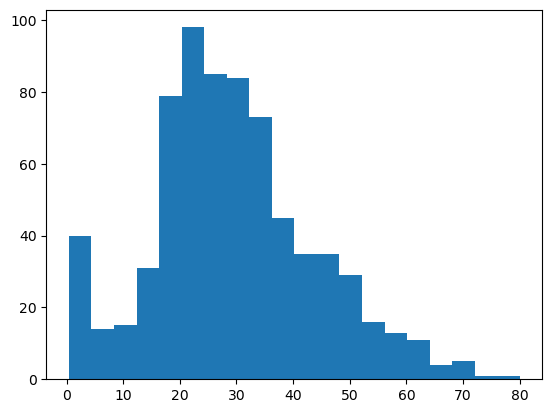

In [5]:
plt.hist(x=df['Age'], bins=20)

Question: Upon visual inspection, does it look normally distributed? Would you expect the data to be normally distributed? Justify your answer.

Answer: No. I would expect the distribution to roughly represent the demographic at the time.
Additionally, I would assume that looking at the demographic is not enough, as the people bording a high class ship like
the Titanic are surely not representing the general population around the time.

Our statistic $f$ in this example will be the mean of the dataset $D$. Let's first calculate it on $D$. 

In [6]:
mean = np.mean(df['Age'])# TODO: Calculate the mean age
mean

29.69911764705882

# Distribution of estimators $\hat{\phi}^b$

Next, we want to simulate $B$ additional datasets as $D^b$ for $b=1,\ldots,B$ and estimate $\hat{\phi}^b$ for each dataset. 

Let's assume that an oracle told you that the true parameters are $\phi=29.7$ and $I^{-1}_N=0.55$. Now, let's investigate to which distribution the bootstrap samples converge with an increasing number of samples $B$.

In [7]:
def bootstrap(B, samples_per_dataset):
    rng = default_rng()

    # TODO: Sample B datasets with samples_per_dataset elements for column "Age"
    samples = rng.choice(df['Age'], size=(B, samples_per_dataset))

    # TODO: Calculate estimator on each dataset
    means = np.mean(samples, axis=1)
    return samples, means

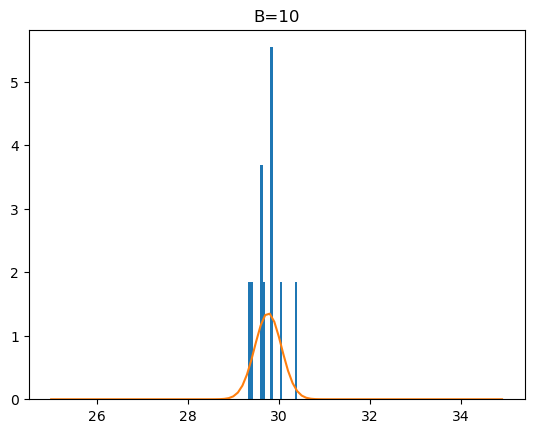

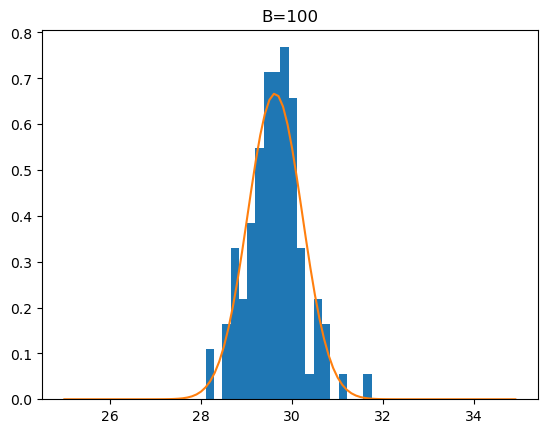

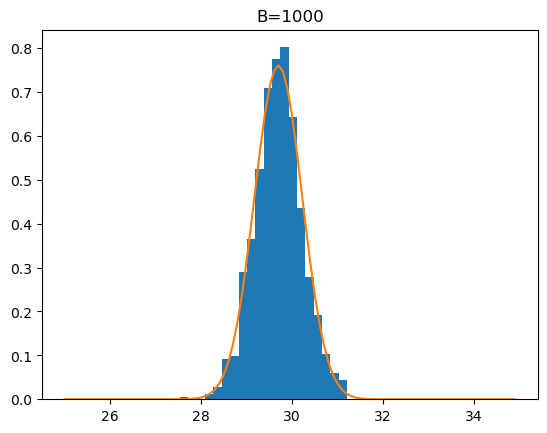

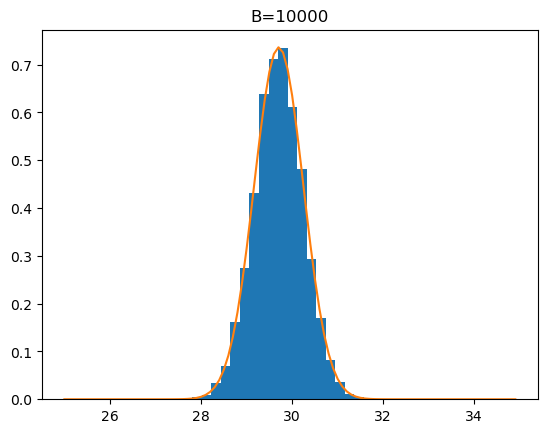

In [15]:
from scipy.stats import norm

samples_per_dataset = df["Age"].size

for B in [10, 100, 1000, 10000]:
    samples, means = bootstrap(B, samples_per_dataset)

    x = np.arange(25, 35, 0.1)
    y = norm.pdf(x, loc=np.mean(means), scale=np.std(means))

    plt.hist(means, bins=20, density=True)
    plt.plot(x, y)
    plt.title(f"{B=}")
    plt.show()

Question: What distribution do you observe? Explain why we get this distribution.

Answer: The distribution seems to converge to a normal distribution. The central limit theorem states, that sampling means from any distribution will converge to a normal distribution.

# Basic Bootstrap/ Reverse Percentile Interval

Using the previously sampled datasets $D^b$ and the estimator $\hat{\phi}$, we now calculate confidence intervals with one of the existing methods: the [Basic Bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Methods_for_bootstrap_confidence_intervals).
With this method, the confidence interval is defined as $(2 \hat{\phi}-\hat{\phi}^B_{1-\alpha/2}, 2 \hat{\phi}-\hat{\phi}^B_{\alpha/2})$ where $\hat{\phi}^B_{\alpha/2}$ is the $\alpha/2$ percentile of all bootstrapped estimators $\hat{\phi}^1, \ldots, \hat{\phi}^B$.

Calculate the 90% confidence interval using the basic bootstrap.

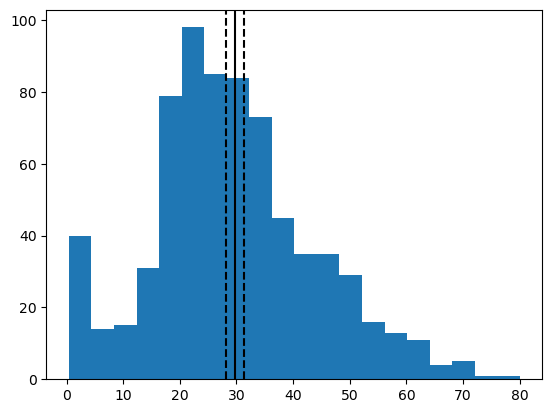

In [19]:
_, means = bootstrap(10000, samples_per_dataset)
mean = np.mean(means)
std = np.std(means)

alpha = 0.05 # TODO: Set alpha
lower_bound = mean - 3*std # TODO: Lower bound of confidence interval
upper_bound = mean + 3*std # TODO: Upper bound of confidence interval

plt.hist(df["Age"], bins=20)
plt.axvline(lower_bound, linestyle='--', color='black') 
plt.axvline(mean, linestyle='-', color='black')
plt.axvline(upper_bound, linestyle='--', color='black')

Now, let's repeat this for $B=10$.

In [20]:
B=10
samples, means = bootstrap(B, samples_per_dataset)

mean = np.mean(means)
std = np.std(means)

lower_bound = mean - 3*std # TODO: Lower bound of confidence interval
upper_bound = mean + 3*std # TODO: Upper bound of confidence interval

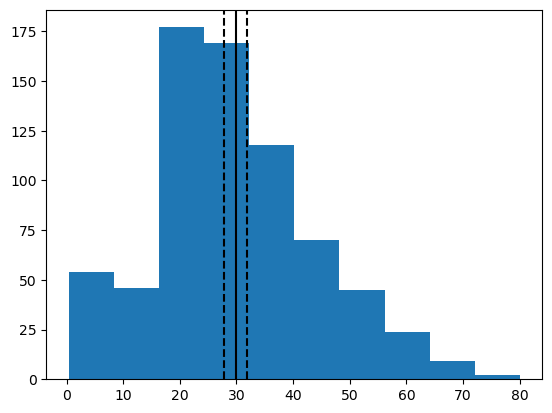

In [21]:
plt.hist(df["Age"])
plt.axvline(lower_bound, linestyle='--', color='black') 
plt.axvline(mean, linestyle='-', color='black')
plt.axvline(upper_bound, linestyle='--', color='black')

Question: What can you observe when comparing the confidence intervals for $B=10$ and $B=10000$? What limitation of bootstrapping does this illustrate?

Answer: The confidence interval for B=10 is larger than at B=10000. 